# Question 2 : Resolution analysis :
Poly:
https://josselin-garnier.org/wp-content/uploads/2025/01/polycopie-mva-2025.pdf#page=44.47

In [13]:
import numpy as np

In [14]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [15]:
import numpy as np

In [16]:
# 1 La green function  on approxime par la partie1


class Green:
    def __init__(self):
        # self.c0=c0,
        # self.zref=zref
        pass

    def __call__(self, w, x, y):
        return (1 / (4 * np.pi * np.linalg.norm(x - y))) * np.exp(
            1j * w * np.linalg.norm(x - y)
        )


f = Green()
f(0, 5, 0)
# f(0,xn[0],zref)

f(1, 5, 6)

(0.04299589137143181+0.06696213335029096j)

In [17]:
# On introduit ici R_n
rho_ref = 1


class R_n:
    # correspond à Rnchapeau
    def __init__(self, rho_ref, f0, f1, zref, xn):
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.xn = xn
        self.zref = zref
        self.green = Green()

    def __call__(self, n, w):
        def rn(n, w):
            # assert w in fband
            if w < self.f0 or w > self.f1:
                return 0
            return self.rho_ref * self.green(w, self.xn[n], zref) ** 2

        return rn(n, w)


R_n(rho_ref, f0, f1, zref, xn)(0, w0)
# R_n(rho_ref,f0,f1,zref_test,xn_test)(0,w0)

(-3.070424805386075e-07+5.371818946225972e-07j)

# créons  l'imaging Function

In [18]:
Tn = 1

In [19]:
class Imagingfun:
    def __init__(self, xn, rho_ref, f0, f1, zref, fband):
        self.xn = xn
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.zref = zref
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn)
        self.fband = fband
        self.M = len(fband)
        self.N = len(xn)
        self.dw = (f1 - f0) / self.M
        self.green = Green()
        self.second_term = self.constructR()

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w)  # +create_noise(1,noise)
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                # second_term=self.rn(n,w)
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

I_fun(zref)

2.494862043068491e-11

# Cas 1 : Pas de bruit
On va plot l'imaging fonction

In [20]:
l_inf_x = -5
l_sup_x = 15

l_inf_y = 90
l_sup_y = 110
res = 10
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))

In [21]:
def compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun):
    x = np.meshgrid(
        np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res)
    )
    # compute the imaging function on the grid
    I_grid = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            I_grid[i, j] = I_fun(np.array([x[0][i, j], x[1][i, j], zref[2]]))
    return I_grid


# plot the imaging function
def compute_maxIcoords(I_grid, zref):
    max_I_index = np.unravel_index(np.argmax(I_grid, axis=None), I_grid.shape)
    max_I_coords = x[0][max_I_index], x[1][max_I_index]
    return max_I_coords


def plot_result(I_grid, zref, max_I_coords, title="Imaging function with no noise"):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(I_grid, extent=(l_inf_x, l_sup_x, l_inf_y, l_sup_y), origin="lower")
    # add a point where the I_fun is maximum

    plt.scatter(
        max_I_coords[0],
        max_I_coords[1],
        s=100,
        c="green",
        label="Maximum found",
        marker="x",
    )
    plt.colorbar()
    plt.title(title)

    plt.scatter(zref[0], zref[1], s=100, c="red", label="zref", marker="x")
    # put the legend out of the img
    plt.legend(loc="upper left", bbox_to_anchor=(5, 1))

    print(
        "Difference between the ground truth and the maxima",
        np.linalg.norm(max_I_coords - zref[:2]),
    )
    plt.show()
    return max_I_coords

Dans un premier temps avec peu de résolution

Difference between the ground truth and the maxima 0.0


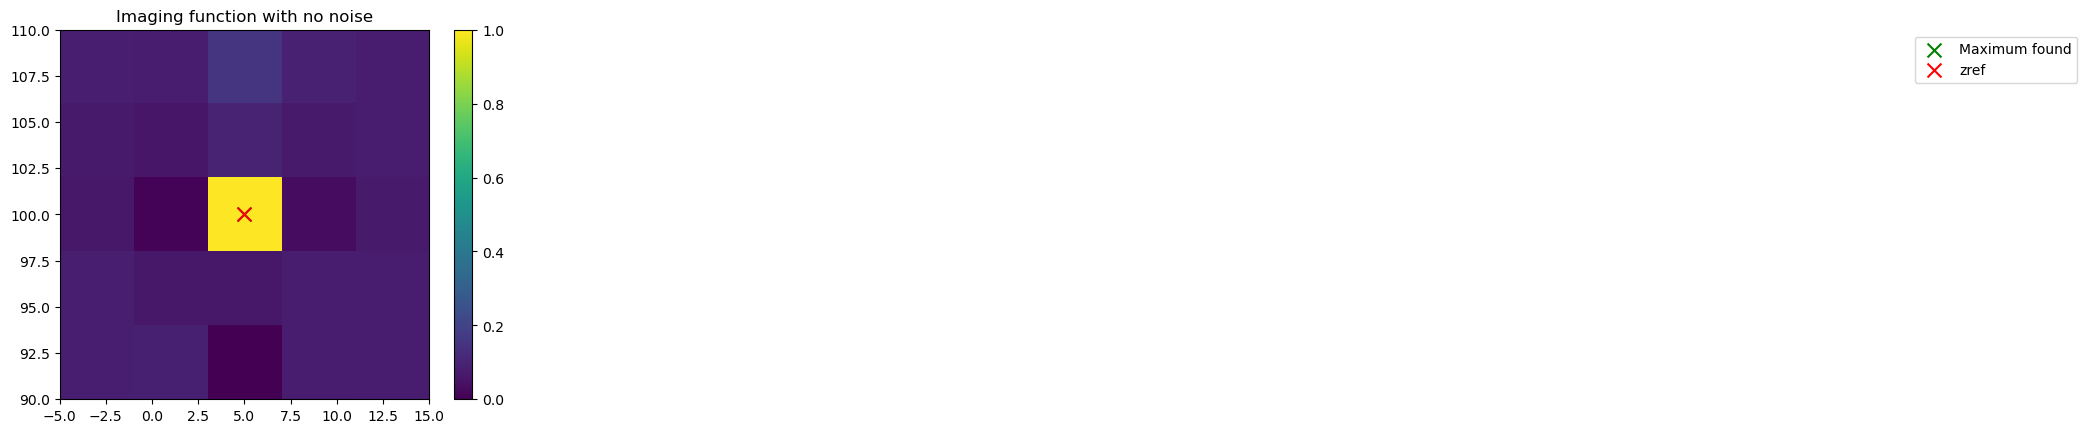

(5.0, 100.0)

In [10]:
res = 5
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
max_I_coords = compute_maxIcoords(I_grid, zref)
plot_result(I_grid, zref, max_I_coords)

On augmente la résolution

Difference between the ground truth and the maxima 0.8333333333333286


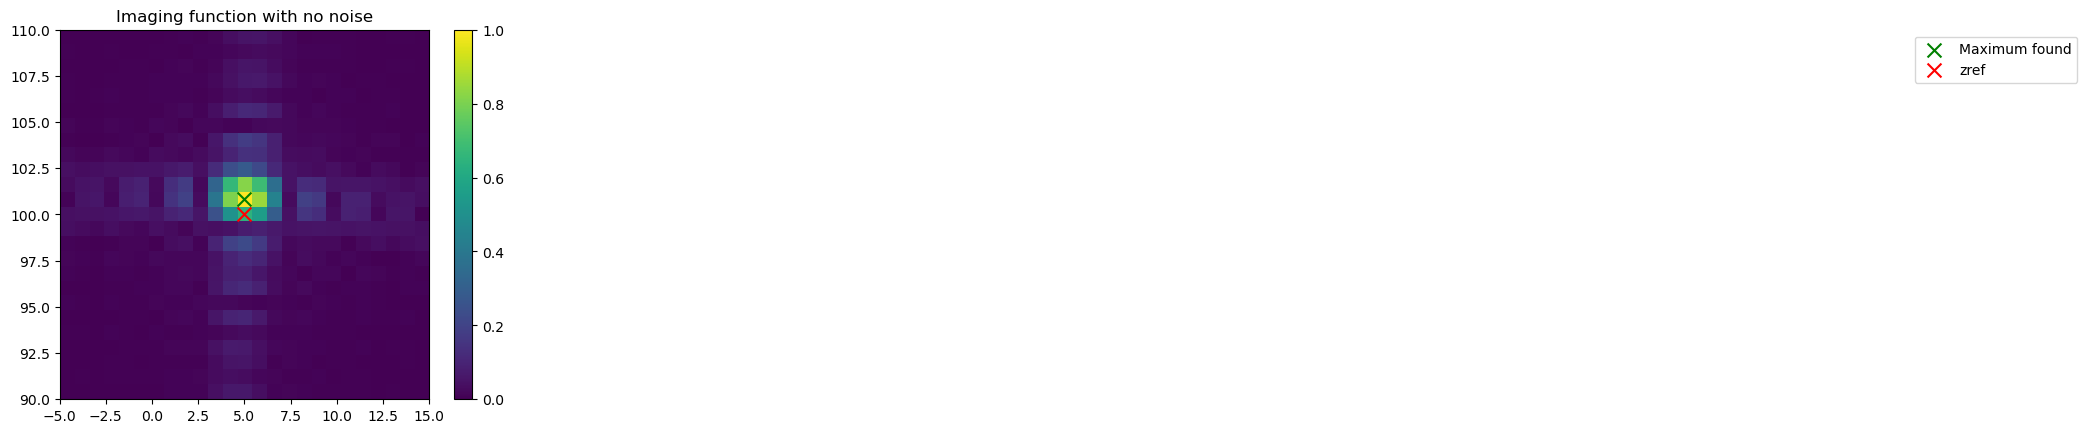

(5.0, 100.83333333333333)

In [22]:
res = 25
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
max_I_coords = compute_maxIcoords(I_grid, zref)
plot_result(I_grid, zref, max_I_coords)

Le maximum théorique et le maximum de la fonction d'image sont très proche. ils ne coincident pas à cause de problème d'intégration et de résolution.

Difference between the ground truth and the maxima 0.8426561840065239


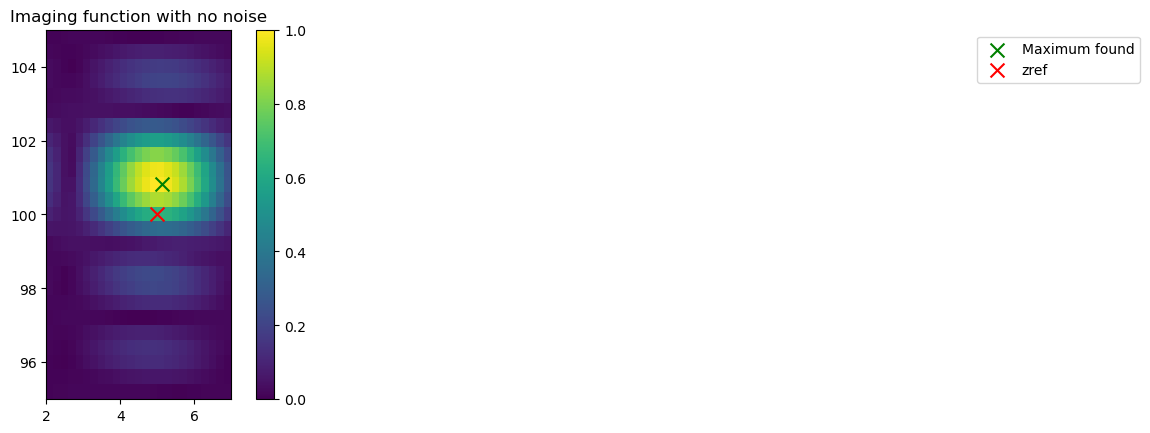

(5.125, 100.83333333333333)

In [23]:
l_inf_x = 2
l_sup_x = 7

l_inf_y = 95
l_sup_y = 105
res = 25
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
max_I_coords = compute_maxIcoords(I_grid, zref)
plot_result(I_grid, zref, max_I_coords)

In [25]:
l_inf_x = -5
l_sup_x = 15

l_inf_y = 90
l_sup_y = 110
res = 25

# Stability Analysis

## First case: Data corrupted by an additive Gaussian Noise

In [26]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64
M = 60
print("REMOE HERE ")
# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

REMOE HERE 


In [27]:
noise = 0.01

In [28]:
# create an complex zero mean gaussian noise
def create_noise(n, sigma):
    z = np.random.normal(loc=0, scale=np.sqrt(2) / 2, size=(n, 2)).view(np.complex128)
    return z * sigma

On crée la fonction d'imagine avec du bruit sur les données

In [29]:
class Imagingfun_antennaNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w) + create_noise(1, self.noise).squeeze()
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun_antennaNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

7.586349886698272e-07

In [30]:
res = 25
noise = 1e-7

In [31]:
import matplotlib.pyplot as plt


def plot_noise(noise, max_I_coords, zref):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem - zref[:2]))
    # plot in log scale
    plt.plot(noise, res)

    plt.xlabel("Noise")

    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima")
    plt.legend()
    return

def plot_noise_xy(noise,max_I_coords,zref):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem[0] - zref[0]))
    # plot in log scale
    plt.plot(noise, res)
    plt.xlabel("Noise")

    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima along the x axis ")
    plt.legend()
    plt.show() 

    fig= plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem[1] - zref[1]))
    # plot in log scale
    plt.plot(noise, res)
    plt.xlabel("Noise")
    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima along the y axis ")
    plt.legend()
    plt.show()
    return

In [32]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

noisel = [10**-k for k in range(1, 4)]


def compute_noise_data(noisel, ntry=10):
    max_I_coordsl = []

    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_antennaNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )
            I_grid = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )
            max_I_coords = compute_maxIcoords(I_grid, zref)

            max_I_coords_average.append(max_I_coords)

            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with noise of level {}".format(noise),
                )

        max_I_coords = np.mean(max_I_coords_average, axis=0)
        # plot it case
        # average the max_I_coords
        max_I_coordsl.append(max_I_coords)
    
    plot_noise(noisel, max_I_coordsl, zref)
    plot_noise_xy(noisel,max_I_coordsl,zref)

On plot en fonction du bruit les maximum trouvé 

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = [10**-k for k in range(2, 7)]
compute_noise_data(noisel)

La différence de distance entre la vérité et le maximum augmente bien avec le bruit. Pour des valeurs de bruits trop élevés, la distance diminue mais cela est dû à la grid trop resérré

On concentre le graphique sur une plage de bruit ou les résultats semble cohérent:

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = np.linspace(5e-5, 1e-07, 10)
compute_noise_data(noisel)

## Dernier cas:  Dans ce cas, la position des récepteurs est inconnus

In [ ]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [ ]:
sigma = 1

On crée ici la fonction d'imagerie correspondante

In [ ]:
class Imagingfun_positionNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)
        xn_noised = xn + np.random.randn(xn.shape[0], xn.shape[1]) * self.noise
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn_noised)
        self.second_term = self.constructR()

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun_positionNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

Dans un premier temps on regarde pour des bruits entre 0.01 et 10

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = [10**k for k in range(-2, 2)]


def compute_noise_postion(noisel, ntry=10):
    max_I_coordsl = []
    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_positionNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )

            I_grid = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )
            max_I_coords = compute_maxIcoords(I_grid, zref)
            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with  Antenna noise of level {} ".format(
                        noise
                    ),
                )

            max_I_coords_average.append(max_I_coords)
        max_I_coords = np.mean(max_I_coords_average, axis=0)
        max_I_coordsl.append(max_I_coords)

    plot_noise(noisel, max_I_coordsl, zref)
    plot_noise_xy(noisel,max_I_coordsl,zref)
    return

In [ ]:
compute_noise_postion(noisel)

On se concentre maintenant au point d'inflexion, i.e entre 0.01 et 0.9 

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = np.linspace(0.01, 0.9, 10)
compute_noise_postion(noisel)

On a bien que la distance augmente avec le bruit. 